<a href="https://colab.research.google.com/github/chunyuan0221/3rd-ML100days/blob/master/Day_086_callback_savebest_saveweight_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
def build_mlp(input_shape, output_neuron=10, layer_neuron=[512, 256, 128]):
    input_layer = keras.layers.Input(shape=input_shape)
    for i, neuron in enumerate(layer_neuron):
        if i == 0:
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=neuron, activation='relu', name='hidden_layer%s'%str(i+1))(x)
        else:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=neuron, activation='relu', name='hidden_layer%s'%str(i+1))(x)
    out = keras.layers.Dense(units=output_neuron, activation='softmax')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
# 設定超參數
EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 1e-2
MOMENTUM = 0.9

In [7]:
# 載入 Callbacks: model checkpoint
from keras.callbacks import ModelCheckpoint
save_best = ModelCheckpoint(filepath='./best.h5',
                             monitor='val_loss',
                             save_best_only=True)

save_normal = ModelCheckpoint(filepath='./normal.h5',
                              monitor='val_loss',
                              save_best_only=False)
checkpoint = [save_best, save_normal]
checkpoint_name = ['save_best', 'no_save_best']
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i in range(len(checkpoint)):
    keras.backend.clear_session()
    print('Experiment of %s' %checkpoint_name[i])
    model = build_mlp(x_train.shape[1:])
    opt = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test, y_test),
              callbacks=[checkpoint[i]],
              shuffle=True)
    
    results[checkpoint_name[i]] = dict(train_loss = model.history.history['loss'],
                                       valid_loss = model.history.history['val_loss'],
                                       train_acc = model.history.history['acc'],
                                       valid_acc = model.history.history['val_acc'])

Experiment of save_best
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6536 - acc: 0.4152 - val_loss: 1.4607 - val_acc: 0.4845
Epoch 2/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.3574 - acc: 0.5202 - val_loss: 1.4057 - val_acc: 0.5017
Epoch 3/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2265 - acc: 0.5662 - val_loss: 1.3744 - val_acc: 0.5110
Epoch 4/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.1180 - acc: 0.6066 - val_loss: 1.3597 - val_acc: 0.5254
Epoch 5/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0270 - acc: 0.6408 - val_loss: 1.3628 - val_acc: 0.5290
Epoch 6/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.9403 - acc: 0.6684 - val_loss: 1.3955 - val_acc: 0.5237
Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.8588 - acc: 0.6999 - va

In [8]:
!ls

best.h5  normal.h5  sample_data  weight_only.h5


In [9]:
model = keras.models.load_model('./best.h5')
loadback_best = model.evaluate(x_test, y_test)

model = keras.models.load_model('./normal.h5')
loadback_normal = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 78us/step


In [10]:
loadback_best

[1.3596763923645019, 0.5254]

In [11]:
loadback_normal

[3.0440115074157714, 0.5346]

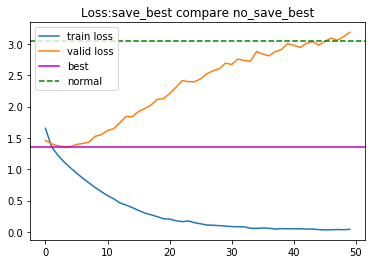

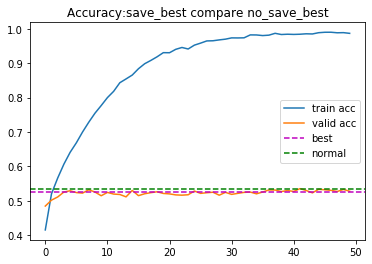

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results[checkpoint_name[0]]['train_loss'], label='train loss')
plt.plot(results[checkpoint_name[0]]['valid_loss'], label='valid loss')
plt.axhline(loadback_best[0], ls='-', color='m', label='best')
plt.axhline(loadback_normal[0], ls='--', color='g', label='normal')
plt.title(f'Loss:{checkpoint_name[0]} compare {checkpoint_name[1]}')
plt.legend()
plt.show()

plt.plot(results[checkpoint_name[0]]['train_acc'], label='train acc')
plt.plot(results[checkpoint_name[0]]['valid_acc'], label='valid acc')
plt.axhline(loadback_best[1], ls='--', color='m', label='best')
plt.axhline(loadback_normal[1], ls='--', color='g', label='normal')
plt.title(f'Accuracy:{checkpoint_name[0]} compare {checkpoint_name[1]}')
plt.legend()
plt.show()

### Result
- 試比較 save_best_only 與否的差異
***
- 在from keras.callbacks import ModelCheckpoint中:
  1. save_best_only=True:不會覆蓋最佳結果的模型。
  2. save_best_only=False:會覆蓋最佳結果，以結束訓練時的作為結果。

- 本次callback的monitor是'val_loss'和'val_acc'。因此，會依據validation data。
- 我們由圖可以觀察到:
  1. Loss : 當save_best_only=True，在loss部分會停在最低點；若save_best_only=False，在loss部分持續更新。
  2. Accuracy : 當save_best_only=True，accuracy會保留準確率最好的地方；若save_best_only=False，則會持續更新同時覆蓋舊資料，導致高準確率的模型被覆蓋。

In [0]:
save_weight = ModelCheckpoint(filepath='./weight_only.h5',
                             monitor='val_loss',
                             save_weights_only=True)

In [14]:
keras.backend.clear_session()
print('Experiment of callbacks weight_only')
model = build_mlp(x_train.shape[1:])
opt = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test, y_test),
          callbacks=[save_weight],
          shuffle=True)

Experiment of callbacks weight_only
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.6450 - acc: 0.4166 - val_loss: 1.4767 - val_acc: 0.4805
Epoch 2/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.3546 - acc: 0.5206 - val_loss: 1.4010 - val_acc: 0.5026
Epoch 3/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2217 - acc: 0.5677 - val_loss: 1.3742 - val_acc: 0.5115
Epoch 4/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.1165 - acc: 0.6076 - val_loss: 1.3522 - val_acc: 0.5270
Epoch 5/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0218 - acc: 0.6400 - val_loss: 1.3685 - val_acc: 0.5272
Epoch 6/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.9372 - acc: 0.6703 - val_loss: 1.3691 - val_acc: 0.5331
Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.8533 - acc:

In [15]:
# 預測test data的結果，用來和之後導入weights檔做比較
print(f'Model evealuate x_test, y_test: {model.evaluate(x_test, y_test)}')

# 看一下weights是否有儲存
!ls

10000/10000 [==============================] - 1s 70us/step
Model evealuate x_test, y_test: [3.071959114074707, 0.5356]
best.h5  normal.h5  sample_data  weight_only.h5


In [16]:
keras.backend.clear_session()
model = build_mlp(x_train.shape[1:])
model.load_weights('weight_only.h5')
# 這邊導入weights還要進行compile不然無法預測
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 73us/step


[3.071959114074707, 0.5356]

### Result
- 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test
***
- save_weights_only=True只會儲存weights；若save_weights_only=False則會儲存整個model。
- 在這邊我們儲存model或weights的方式是透過fit時，加入callbacks的指令來進行，但我們也可以在fit完後，再進行model.save將整個模型儲存，另外也可透過model.save_weights單純存取weights。
- Model checkpoint 可以根據隨時將模型存下來，如此可以保證：
  1. 假如不幸訓練意外中斷，前面的訓練也不會白費。我們可以從最近的一次繼續重新開始
  2. 我們可以透過監控validation loss來保證所存下來的模型是在validation set表現最好的一個。